# Determining Sigma 10, Sigma 20 & R 10, R 20 of DESIJ0215-2909

Author(s): Nusrath Jahan, Anowar Shajib, S M Rafee Adnan

## Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [2]:
data, header = fits.getdata("./DESIJ0215-2909_F140W_drz_sci.fits", header=True)

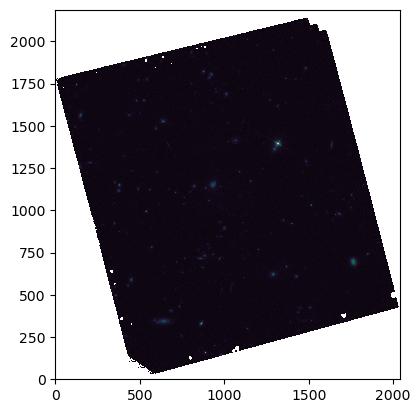

In [3]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_7510/1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


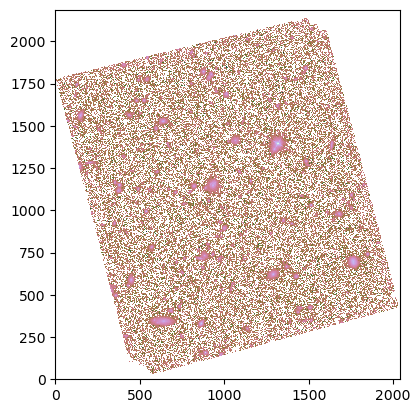

In [5]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [6]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.31832204500101835, 0.013773692784527596)

In [7]:
bkg_subtracted_data = data - bkg.background

In [8]:
threshold = 4 * bkg.background_rms

In [9]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [10]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [11]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2188, 2039)
nlabels: 588
labels: [  1   2   3   4   5 ... 584 585 586 587 588]


In [12]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 588
labels: [  1   2   3   4   5 ... 584 585 586 587 588]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_7510/3723893348.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


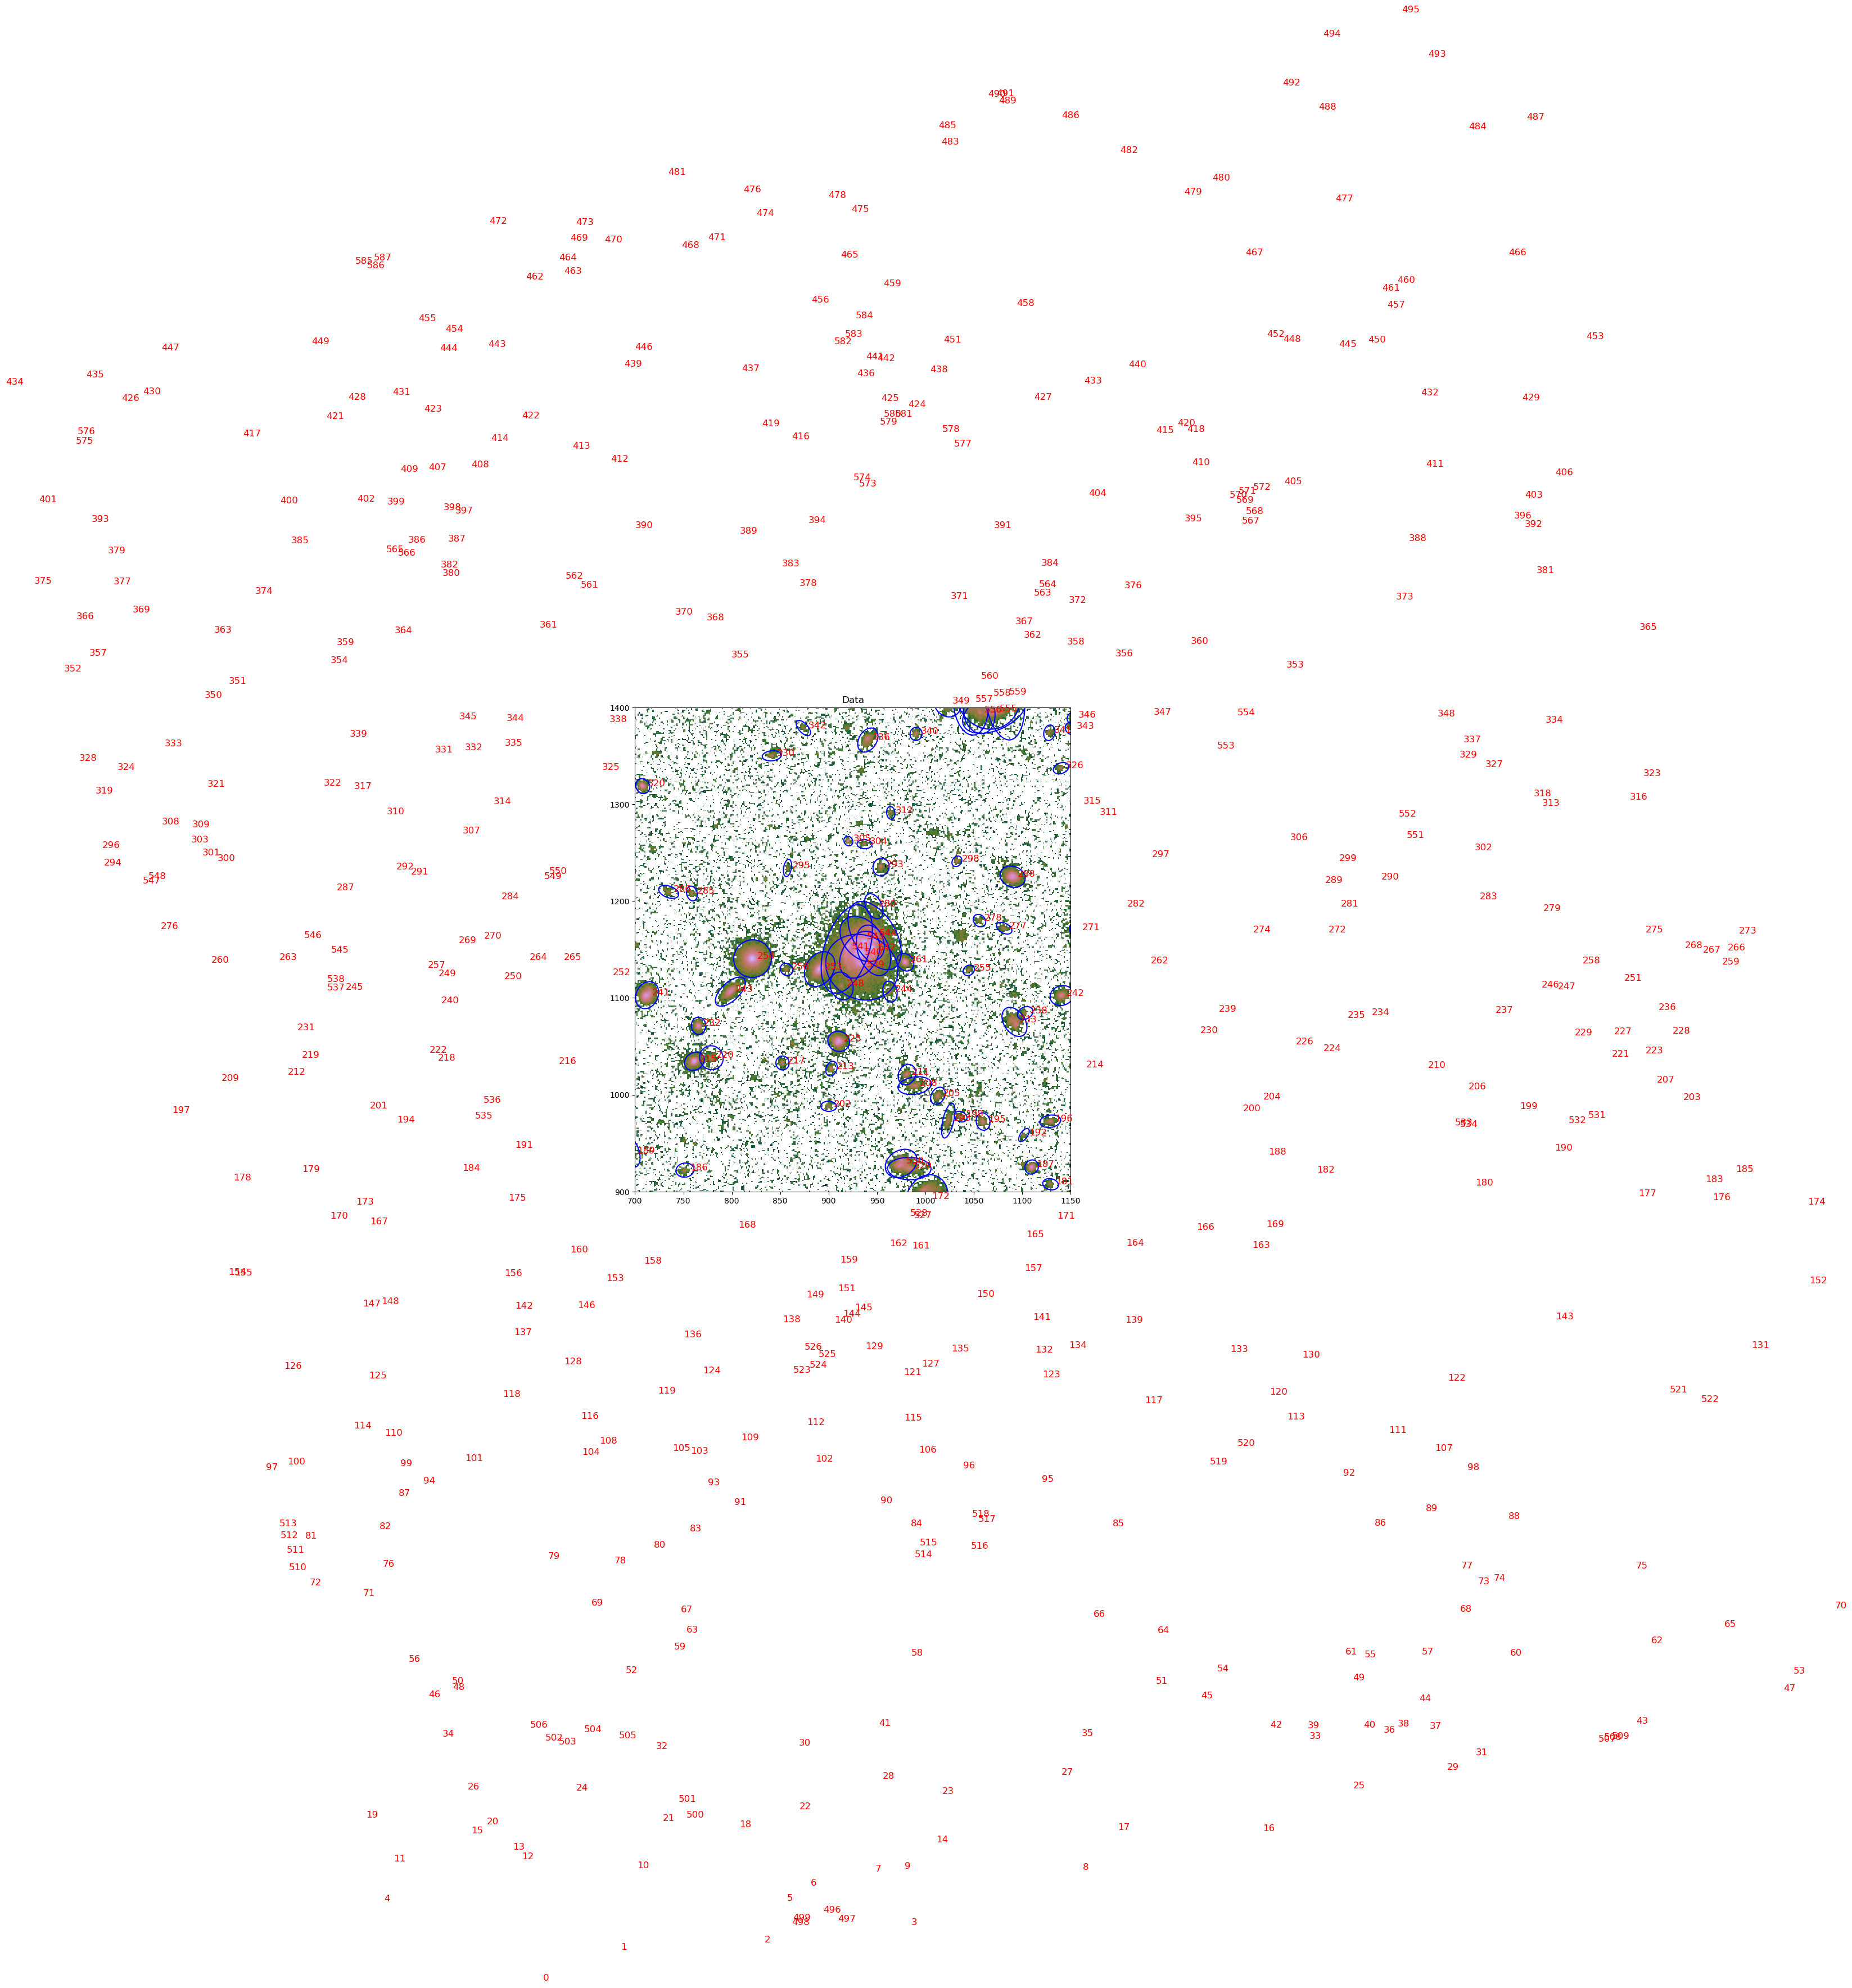

In [13]:
set_x_lim1, set_x_lim2 = 700, 1150
set_y_lim1, set_y_lim2 = 900, 1400

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in range(len(cat)):
    ax1.text(
        cat.xcentroid[i] + 5,
        cat.ycentroid[i],
        f"{i}",
        c="r",
        fontsize=12
        # transform=ax1.transAxes
    )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_7510/3090931970.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


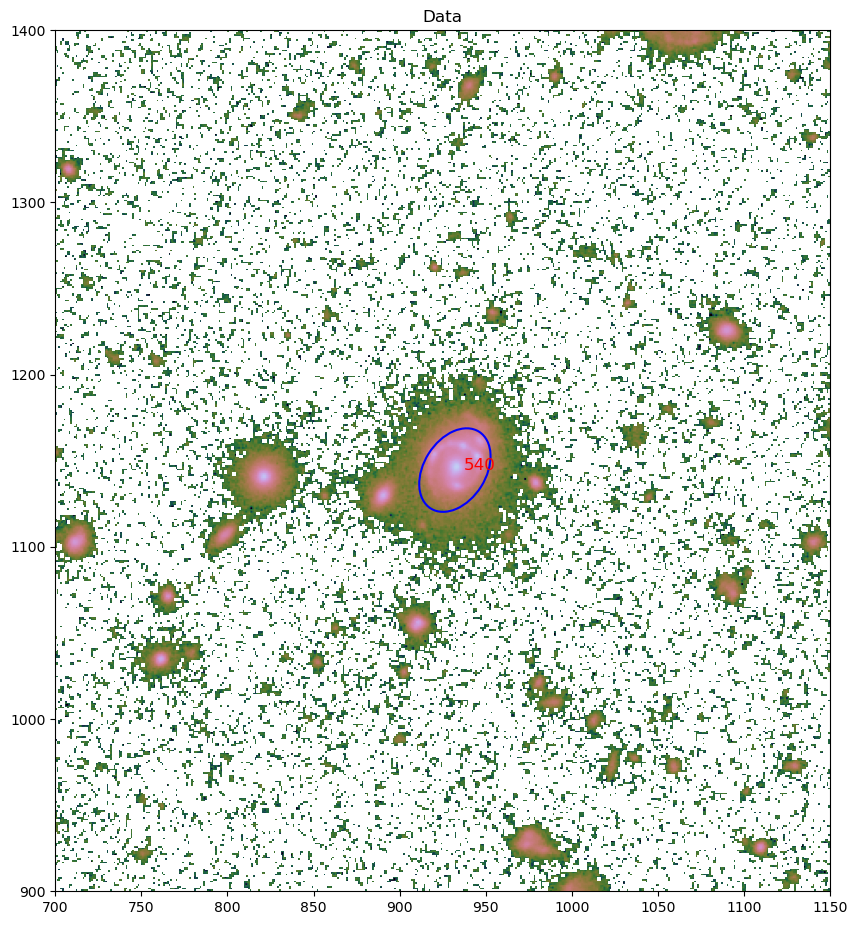

In [17]:
# object id of your central deflector/lens
id_central = 540

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [26]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [19]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        print(i)
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
print("Number of All Close galaxies:", len(close_galaxies_all))

193
195
198
202
205
208
211
213
215
217
220
225
232
233
238
241
242
243
244
248
253
254
255
256
261
271
277
278
280
285
286
288
293
295
298
304
305
312
330
336
340
342
529
530
539
540
541
542
543
544
Number of All Close galaxies: 50


In [20]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        print(i)
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
print("Number of Close galaxies dim sources:", len(close_galaxies_1))

193
195
205
208
211
215
220
225
232
233
241
242
243
244
248
253
254
261
271
280
288
293
336
340
529
530
539
540
541
542
543
544
Number of Close galaxies dim sources: 32


In [21]:
def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [22]:
n_sys = 5  # number of galaxies detected inside your lensing system

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_all_sys_removed = df_all_sorted.iloc[n_sys:]

# first 10 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux
544         25.026981          2.002158  175.921829
248         37.335958          2.986877   17.407662
253         43.888838          3.511107  108.766054
261         47.765238          3.821219   27.014060
244         49.299038          3.943923    6.149716
280         52.132461          4.170597    7.383340
256         77.082668          6.166613    3.160074
225         92.038674          7.363094   62.809333
293         93.200487          7.456039    6.248890
254        110.686694          8.854936  209.860834
255        113.829602          9.106368    2.399646
304        114.243942          9.139515    2.027332
295        116.556230          9.324498    1.660257
305        117.912118          9.432969    3.409737
213        121.199289          9.695943    4.113972
278        128.620821         10.289666    2.154768
211        133.088020         10.647042    9.491942
217        137.286056         10.982884    4.357146
243        1

In [23]:
# number of galaxies detected inside your lensing system

df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.iloc[n_sys:]

# first 10 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux
544         25.026981          2.002158  175.921829
248         37.335958          2.986877   17.407662
253         43.888838          3.511107  108.766054
261         47.765238          3.821219   27.014060
244         49.299038          3.943923    6.149716
280         52.132461          4.170597    7.383340
225         92.038674          7.363094   62.809333
293         93.200487          7.456039    6.248890
254        110.686694          8.854936  209.860834
211        133.088020         10.647042    9.491942
243        138.912732         11.113019   36.875140
208        146.637083         11.730967   12.456071
205        166.558359         13.324669    6.938395
233        174.244092         13.939527   22.221573
288        177.370944         14.189676   62.668680
232        181.906551         14.552524   20.332989
220        186.472546         14.917804    8.755138
193        194.182225         15.534578    7.591163
215        2

## Determining Sigma 10, 20 and R 10, 20

/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_7510/811589809.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_7510/811589809.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_7510/811589809.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_7510/811589809.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: 10.647041568012046
R 20: 17.037674755907055
Sigma 10: 0.028079684773456532
Sigma 20: 0.02193105257864528

FOR All SOURCES
R 10: 8.854935511689188
R 20: 11.132552175432485
Sigma 10: 0.04059563340045878
Sigma 20: 0.05136776197437483


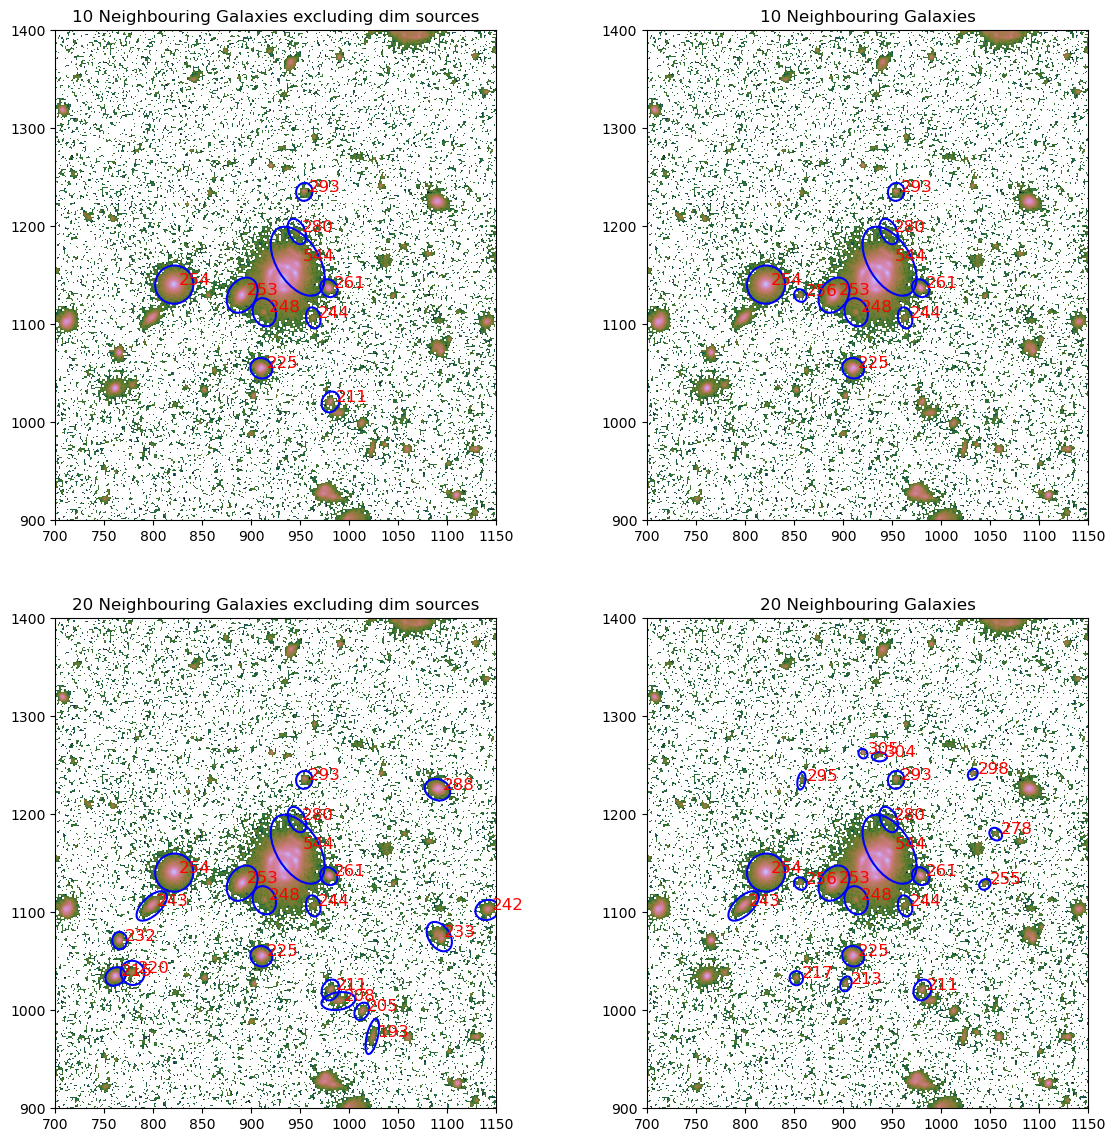

In [24]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

In [25]:
%store R_10_1
%store R_20_1
%store Sigma_10_1
%store Sigma_20_1

%store R_10_all
%store R_20_all
%store Sigma_10_all
%store Sigma_20_all

Stored 'R_10_1' (float64)
Stored 'R_20_1' (float64)
Stored 'Sigma_10_1' (float64)
Stored 'Sigma_20_1' (float64)
Stored 'R_10_all' (float64)
Stored 'R_20_all' (float64)
Stored 'Sigma_10_all' (float64)
Stored 'Sigma_20_all' (float64)
